Number of columns before dropped columns: 1569
Number of columns after dropped columns: 205


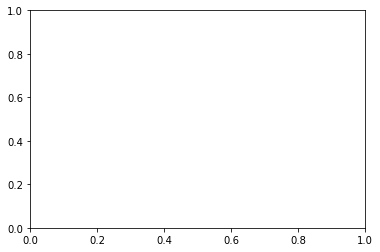

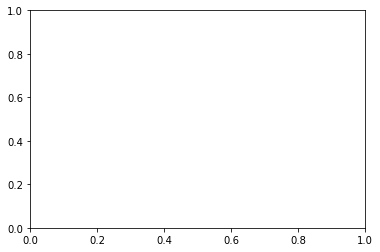

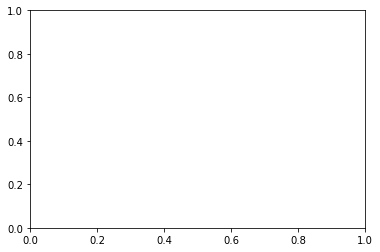

In [1]:
# LOG OF CHANGES
# In feite v3.0 met cortisol weer weggehaald

import os
import sys
clear = lambda: os.system('cls')  # On Windows System
clear()
sys.path.insert(0, r'C:\Users\linda\Dropbox\TM\Stagedocumenten\Q2 2021-2022\IDA-model-main\IDA-model\Functions')
# Import the right data packages
import pandas as pd
import numpy as np
import seaborn as sns
from v1_baseline import baseline
from v1_drop_data import drop_data
from v1_feature_selection import find_sign_features
from v1_impute_data import impute_data
from v1_load_data import load_data
from v1_mean_ROC_curves import mean_ROC_curves
from v1_pipeline_model import pipeline_model
from v1_scale_data import scale_data
from v1_stratify import stratify
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy import stats
from statistics import mean
from statistics import stdev
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Load and merge data. Define paths and columns wanted from Excel files
path_data = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v6_dataset.xlsx'
columns_data = "A:BBB"
path_labels = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/IDA_aangevuld.xls'
columns_labels = "A:B"
path_phecodes = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/phecodes_filled_binary.xlsx'
columns_phecodes = "A:R"
path_specialisms = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/Letters_DBC_combined.xlsx'
columns_specialisms = "A:BW"
path_decimals = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/afronden_features.xlsx'
columns_decimals = 'A:HI'
path_baseline = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/baseline.xlsx'
columns_baseline = 'A:C'
path_extra = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v3_extra.xlsx'
columns_extra = 'A:D'
path_brieven = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v2_brieven.xlsx'
columns_brieven = 'A:BR'
path_syndromen = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v1_syndromen.xlsx'
columns_syndromen = 'A:B'

# df data contains most of the features needed to build the model
df_data = load_data(path_data, columns_data)
# df labels contains the label ID/ no ID
df_labels = load_data(path_labels, columns_labels)
# df phecodes contains the data about the diagnoses a patient has, categorized into groups
df_phecodes = load_data(path_phecodes, columns_phecodes)
# df spec contains the data about what specialisms a patient visited
df_spec = load_data(path_specialisms, columns_specialisms)
# df decimal contains the amount of decimals for rounding the different features
df_decimal = load_data(path_decimals, columns_decimals)
# df baseline contains baseline characteristics age and gender
df_baseline = load_data(path_baseline, columns_baseline)
# df_extra contains extra characteristics like BMI and opnames
df_extra = load_data(path_extra, columns_extra)
# df_brieven contains the letters sent from specialisms
df_brieven = load_data(path_brieven,columns_brieven)
# df_syndromen contains the PIDs and syndrome code
df_syndromen = load_data(path_syndromen,columns_syndromen)

# Merge dataframes
df_hix_spec = df_data.merge(df_spec, on='Pt_no', how='outer')
df_hix_phecodes = df_hix_spec.merge(df_phecodes, on='Pt_no', how='outer')
# In df hix, all features are merged inside one dataframe. The specialisms, phecodes and labels are added
df_hix = df_hix_phecodes.merge(df_labels, on='Pt_no', how='inner')
# Now add all the extra features
df_ex = df_hix.merge(df_extra, on='Pt_no',how = 'inner')
# Now add the letters from the specialisms
df_all = df_ex.merge(df_brieven, on = 'Pt_no', how = 'inner')
print('Number of columns before dropped columns: ' + str(len(df_all.columns)))

# Defining thresholds for dropping rows and columns with missing data (threshold of amount of non-NA values required)
threshold_column = 0.6
threshold_row = 0.5

# Drop columns and rows with too many NaN's
df_dropped = drop_data(threshold_column, threshold_row, df_all)
print('Number of columns after dropped columns: ' + str(len(df_dropped.columns)))

# Balance set by picking random samples from no ID group # hierrr
df_ID_1 = df_dropped.loc[df_dropped['Label'] == 1.0]
df_ID_0_all = df_dropped.loc[df_dropped['Label'] == 0.0]

# To perform stratified random sampling, the gender of the ID group is checked
# Check baseline characteristics of subset
# Merge the dataframes of ID and no ID with the baseline characteristics in df baseline (age and gender)
# Exploratory data analysis
df_0_all_baseline = df_ID_0_all.merge(df_baseline, on='Pt_no', how='inner')
df_1_baseline = df_ID_1.merge(df_baseline, on='Pt_no', how='inner')
#characteristics = baseline(df_0_all_baseline, df_1_baseline)

# Stratify the data
df_control = stratify(df_0_all_baseline, df_1_baseline)

# Nou moeten de dataframes van no ID en ID weer bij elkaar 
df_comb = pd.concat([df_1_baseline,df_control])
df_comb = df_comb.drop(['Leeftijd', 'Geslacht'], axis = 1 )

# Defining empty lists needed later
tprs_RF_all = []
aucs_RF_all = []
auc_RF_all = []
spec_RF_all = []
sens_RF_all = []
accuracy_RF_all = []
tprs_RF_fin = []
aucs_RF_fin = []
auc_RF_fin = []
spec_RF_fin = [] 
sens_RF_fin = []
accuracy_RF_fin = []
tprs_SVM_fin = []
aucs_SVM_fin = [] 
auc_SVM_fin = []
spec_SVM_fin = [] 
sens_SVM_fin = []
accuracy_SVM_fin = []
accuracy_SVM_sign = []
perm_importances_dfs = []
sign_features_dfs = []

# Define the necessary figures
_, axis_RF_all = plt.subplots()
_, axis_RF_fin = plt.subplots()
_, axis_SVM_fin = plt.subplots()

# Define data and labels
labels = df_comb['Label']
data = df_comb.drop(['Pt_no', 'Label'], axis=1)

# Define ordinal, binary and continuous keys
ordinal_keys = ['Anti-epileptics', 'Psychofarmaca', 'Antacids', 'Anti-hypertensives', 'VitB12', 'Iron-tablets', 'Specialisms_hospitalization', 'Radiologic_investigations', 'Total_amount_ICD10s']
binary_keys = list(df_spec.keys()) + list(df_phecodes.keys()) + list(df_brieven.keys())
binary_keys.remove('Pt_no')
binary_keys.remove('Pt_no')
binary_keys.remove('Pt_no')
#continuous_keys = ['Length', 'Opnames_spec', 'Beeldvormende_verr', 'HR', 'RRsyst', 'RRdiast', 'Vrij T4', 'Hemolytische index', 'Icterische index', 'Lipemische index', 'TSH', 'Alk.Fosf.', 'ALAT', 'ASAT', 'Calcium', 'CKD-EPI eGFR', 'Glucose/PL', 'Hemoglobine', 'Kalium', 'Kreatinine', 'LDH', 'MCV', 'Natrium', 'RDW', 'Tot. Bilirubine', 'Gamma-GT', 'Ureum', 'BMI']
continuous_keys = ['Length', 'Opnames_spec', 'Beeldvormende_verr', 'HR', 'RRsyst', 'RRdiast', 'FSH', 'Vrij T4', 'Hemolytische index', 'Icterische index', 'Lipemische index', 'TSH', 'Alk.Fosf.', 'ALAT', 'Albumine', 'ASAT', 'Calcium', 'CKD-EPI eGFR', 'Glucose/PL', 'Hemoglobine', 'Kalium', 'Kreatinine', 'LDH', 'Leukocyten', 'MCV', 'Natrium', 'RDW', 'Tot. Bilirubine', 'Trombocyten', 'Gamma-GT', '25-OH Vitamine D', 'Ureum', 'LDL-Cholesterol', 'BMI']

# Test data splitten uit totale dataset
train_data2, test_data2 = train_test_split(df_comb, test_size=0.1, random_state=5)
train_data = train_data2.drop(['Pt_no', 'Label'], axis=1)
test_data = test_data2.drop(['Pt_no', 'Label'], axis=1)
train_label = train_data2['Label']
test_label = test_data2['Label']

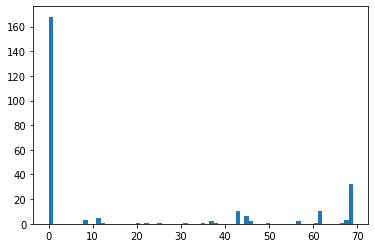

Syndrome distribution in control group:
0.0:168
8.0:3
62.0:10
69.0:32
45.0:6
43.0:10
37.0:2
68.0:3
67.0:1
20.0:1
35.0:1
50.0:1
11.0:5
12.0:1
25.0:1
61.0:1
57.0:2
22.0:1
38.0:1
46.0:2
31.0:1


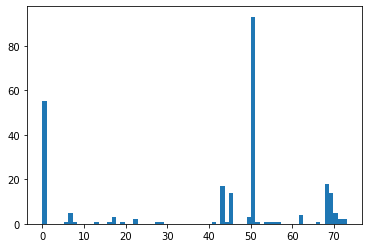

Syndrome distribution in ID group:
51.0:93
56.0:1
70.0:5
62.0:4
41.0:1
0.0:54
7.0:5
44.0:1
71.0:2
1.0:1
69.0:14
45.0:14
43.0:17
57.0:1
22.0:2
50.0:3
17.0:3
68.0:18
16.0:1
66.0:1
73.0:1
54.0:1
29.0:1
55.0:1
13.0:1
52.0:1
6.0:1
8.0:1
72.0:1
19.0:1
28.0:1


In [2]:
# Syndromen bekijken
# nu nog beter plotten en in een functie gooien
# Controle groep
# eerst even alle missings veranderen naar 0
df_syndromen = df_syndromen.fillna(0)

syndroom_control = []
for pt in df_control['Pt_no']:
    slice = df_syndromen.loc[df_syndromen['Pt_no'] == pt]    # Fill dataframe with p-values
    syndroom = slice['Syndroom'].item()
    syndroom_control.append(syndroom)
#print(syndroom_control)
plt.hist(syndroom_control, bins = 70)
plt.show()
# initialize a dictionary to store the frequency of each element
control_count = {}
for element in syndroom_control:
    if element in control_count:
        control_count[element] += 1
    else:
        control_count[element] = 1

print("Syndrome distribution in control group:")

for key, value in control_count.items():
    print(f"{key}:{value}")

# VB groep

syndroom_ID = []
for pt in df_1_baseline['Pt_no']:
    slice = df_syndromen.loc[df_syndromen['Pt_no'] == pt]    # Fill dataframe with p-values
    syndroom = slice['Syndroom'].item()
    syndroom_ID.append(syndroom)
#print(syndroom_ID)
# Verwijder de waarde 999 want daar hebben we toch niets aan
syndroom_ID.remove(999.0)
plt.hist(syndroom_ID, bins = 70)
plt.show()
# initialize a dictionary to store the frequency of each element
ID_count = {}
for element in syndroom_ID:
    if element in ID_count:
        ID_count[element] += 1
    else:
        ID_count[element] = 1
print("Syndrome distribution in ID group:")
for key, value in ID_count.items():
    print(f"{key}:{value}")

In [3]:
print('Number of people after dropped rows: ' + str(len(df_dropped.index)))
print('Number of controls after dropped rows: ' + str(len(df_control.index)))


Number of people after dropped rows: 1094
Number of controls after dropped rows: 253


In [4]:
# # # Stukje code om de namen van de gedropte kolommen te kunnen printen
# for name in df_all.columns:
#    if name not in df_dropped.columns:
#        print(name)

# # for name in df_dropped.columns:
# #     print(name)

In [5]:
# Test data splitten uit totale dataset
# train_data2, test_data2 = train_test_split(df_comb, test_size=0.1, random_state=25)
# train_data = train_data2.drop(['Pt_no', 'Label'], axis=1)
# test_data = test_data2.drop(['Pt_no', 'Label'], axis=1)
# train_label = train_data2['Label']
# test_label = test_data2['Label']

# Waarom doen we de preprocessing ook niet gewoon hier

In [6]:
# Define 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state= 4)

for i, (train_index, val_index) in enumerate(cv_10fold.split(train_data, train_label)):    # Split the data in a train and validation set in a 10-fold cross-validation
    data_train = train_data.iloc[train_index]
    label_train = train_label.iloc[train_index]
    data_val = train_data.iloc[val_index]
    label_val = train_label.iloc[val_index]
 
    # Pre-processing steps
    # Impute data, but exclude the BMI in this. Add BMI again after imputation.
    impute_train, impute_val = impute_data(data_train, data_val, df_decimal) #imputes data for all columns 
    # Imputed lentgh and weight, now calculate BMI from that and delete weight again
    impute_train['BMI'] = np.round(impute_train['Weight']/((impute_train['Length']/100)**2), decimals=2)
    impute_val['BMI'] = np.round(impute_val['Weight']/((impute_val['Length']/100)**2), decimals=2)
    impute_train = impute_train.loc[:,impute_train.columns!='Weight']
    impute_val = impute_val.loc[:,impute_val.columns!='Weight']

    # Find significant features per fold
    #sign, sign_features_dfs = find_sign_features(impute_train, label_train, train_index, ordinal_keys, binary_keys, continuous_keys, sign_features_dfs)
    sign, sign_features_dfs = find_sign_features(impute_train, label_train, train_index, ordinal_keys, binary_keys, continuous_keys, sign_features_dfs)

    # Make new dataframes with the significant features
    # train_sign=impute_train[sign]
    # val_sign=impute_val[sign]

    # Scale the data
    # scale_train, scale_val = scale_data(impute_train, impute_val, continuous_keys, ordinal_keys)

    # Define classifiers
    clf_RF_all = RandomForestClassifier()

    # Implement wrapper feature selection
    # sfs1 = sfs(clf_RF_all, k_features=5, forward= False, verbose = 1, scoring = 'neg_mean_squared_error')
    # sfs2 = sfs1.fit(impute_train, label_train) # executing feature selection
    # feat_names = list(sfs2.k_feature_names_)
    # print(f'These are the chosen features for this fold: {feat_names}')
    # Create and test three different models: random forest with all features, random forest with significant features only and support vector machine with only significant features
    # Random forest with all features: create model
    #tprs_RF_all, aucs_RF_all, auc_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, gini_RF_all = pipeline_model(impute_train, label_train, impute_val, label_val, clf_RF_all, tprs_RF_all, aucs_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, axis_RF_all)
    tprs_RF_all, aucs_RF_all, auc_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, gini_RF_all = pipeline_model(impute_train, label_train, impute_val, label_val, clf_RF_all, tprs_RF_all, aucs_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, axis_RF_all)

    # Random forest with significant features only: create model
    #tprs_RF_all, aucs_RF_all, auc_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, gini_RF_all = pipeline_model(impute_train[sign], label_train, impute_val[sign], label_val, clf_RF_all, tprs_RF_all, aucs_RF_all, spec_RF_all, sens_RF_all, accuracy_RF_all, axis_RF_all) # met alleen maar significante features (lagere scores)
    # Random forest with all features: Calculate permutation feature importance
    #result = permutation_importance(clf_RF_all, impute_val[sign], label_val, n_repeats=10, random_state=42, n_jobs=2) # met alleen maar significante features (lagere scores)
    result = permutation_importance(clf_RF_all, impute_val, label_val, n_repeats=10, random_state=42, n_jobs=2) 
    # Create dataframe to store the results
    #df_feature_importance = pd.DataFrame({'Feature': (list(impute_train[sign].columns)), 'Feature importance mean': result.importances_mean, 'Feature importance std': result.importances_std})
    df_feature_importance = pd.DataFrame({'Feature': (list(impute_train.columns)), 'Feature importance mean': result.importances_mean, 'Feature importance std': result.importances_std}) # met alleen maar significante features (lagere scores)

    # Sort dataframe with the most important features first. Keep only the 5 most important features with .head()
    df_feature_importance_sorted = df_feature_importance.sort_values(by=['Feature importance mean'], ascending=False).head()
    # Append dataframe to list per fold. The list consists of i dataframes for the number of folds, showing the best 5 features per fold. This dataframe can be used for visualization.
    perm_importances_dfs.append(df_feature_importance_sorted)

    print(f'This is fold {i}')


This is fold 0
This is fold 1
This is fold 2
This is fold 3
This is fold 4
This is fold 5
This is fold 6
This is fold 7
This is fold 8
This is fold 9


In [7]:
# Now, create a dataframe with all duplicate features removed
rel_features_df = pd.DataFrame()
for fold in perm_importances_dfs:
    rel_features_df = pd.concat([rel_features_df, fold])
rel_features_df = rel_features_df.drop_duplicates(subset=['Feature'])
# Make a list of the relevant features
rel_features = rel_features_df['Feature'].tolist()
print(f'These are the relevant features {rel_features}')
# Next, create new dataframes of the training and test data with only these relevant features and preprocess the data)
# Pre-processing steps
# Impute data
impute_train_rel, impute_test_rel = impute_data(train_data, test_data, df_decimal)
# Imputed length and weight, now calculate BMI from that and delete weight again
impute_train_rel['BMI'] = np.round(impute_train_rel['Weight']/((impute_train_rel['Length']/100)**2), decimals=2)
impute_test_rel['BMI'] = np.round(impute_test_rel['Weight']/((impute_test_rel['Length']/100)**2), decimals=2)
impute_train_rel = impute_train_rel.loc[:,impute_train_rel.columns!='Weight']
impute_test_rel = impute_test_rel.loc[:,impute_test_rel.columns!='Weight']
# Select only the relevant features
impute_train_fin = impute_train_rel[rel_features]
impute_test_fin = impute_test_rel[rel_features]

# Scale the data
scale_train_rel, scale_test_rel = scale_data(impute_train_rel, impute_test_rel, continuous_keys, ordinal_keys)
# Again, only select the relevant features
scale_train_fin = scale_train_rel[rel_features]
scale_test_fin = scale_test_rel[rel_features]

# Train a SVM and RF classifier using all the training data and validate on the remaining 10% of unseen data
# Define classifiers
clf_RF_fin = RandomForestClassifier()
clf_SVM_fin = SVC()

# Random forest with significant features only: create model
tprs_RF_fin, aucs_RF_fin, auc_RF_fin, spec_RF_fin, sens_RF_fin, accuracy_RF_fin, gini_RF_fin = pipeline_model(impute_train_fin, train_label, impute_test_fin, test_label, clf_RF_fin, tprs_RF_fin, aucs_RF_fin, spec_RF_fin, sens_RF_fin, accuracy_RF_fin, axis_RF_fin)

# Support vector machine with significant features only: create model with scaled data
tprs_SVM_fin, aucs_SVM_fin, auc_SVM_fin, spec_SVM_fin, sens_SVM_fin, accuracy_SVM_fin, gini_SVM_fin = pipeline_model(scale_train_fin, train_label, scale_test_fin, test_label, clf_SVM_fin, tprs_SVM_fin, aucs_SVM_fin, spec_SVM_fin, sens_SVM_fin, accuracy_SVM_fin, axis_SVM_fin)



These are the relevant features ['Length', 'CKD-EPI eGFR', 'Leukocyten', 'GYN', 'Ureum', 'Kreatinine', 'Icterische index', 'Brief_URO', 'Psychofarmaca', 'Brief_GYN', 'GGZ', 'LDL-Cholesterol', 'RRdiast', '25-OH Vitamine D', 'Antacids', 'Calcium', 'HR', 'Hemolytische index', 'KIN', 'OOG', 'Brief_KHA', 'Brief_INT', 'KNO', 'RDW', 'ASAT', 'Brief_END', 'BMI', 'Anti-epileptics', 'Tot. Bilirubine', 'ALAT', 'Specialisms_hospitalization', 'RRsyst', 'Albumine']


In [8]:
plt.show()

# Create a dictionary of the scores for the two models. Create dataframe for visualisation.
dict_scores = {'Model 1: Random Forest':[f'{np.round(accuracy_RF_fin, decimals = 2)}',
                                        f'{np.round(sens_RF_fin, decimals=2)}',
                                        f'{np.round(spec_RF_fin, decimals=2)}',
                                        f'{np.round(aucs_RF_fin,decimals=2)}',
                                        f'{np.round(gini_RF_fin,decimals=2)}'],
            'Model 2: Support Vector Machine':[f'{np.round(accuracy_SVM_fin,decimals=2)}',
                                        f'{np.round(sens_SVM_fin,decimals=2)}',
                                        f'{np.round(spec_SVM_fin,decimals=2)}',
                                        f'{np.round(aucs_SVM_fin,decimals=2)}',
                                        f'{np.round(gini_SVM_fin,decimals=2)}']}

df_scores = pd.DataFrame.from_dict(dict_scores, orient='index', columns=['Accuracy', 'Sensitivity', 'Specificity', 'Area under ROC-curve','Gini index'])

print(df_scores)

                                Accuracy Sensitivity Specificity  \
Model 1: Random Forest            [0.78]      [0.89]      [0.72]   
Model 2: Support Vector Machine   [0.75]      [0.79]      [0.72]   

                                Area under ROC-curve Gini index  
Model 1: Random Forest                        [0.84]       0.69  
Model 2: Support Vector Machine               [0.82]       0.63  
